# Use to explore and find issues with registry metadata

## Setup

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## show time that this notebook was executed 
from datetime import datetime

## packages to work with objects 
import re
import requests
import pandas as pd
from textwrap import wrap  ## for plot labels

## to get around bugs
import nest_asyncio
nest_asyncio.apply()

In [2]:
## record when cell blocks are executed
print('The time that this notebook was executed is...')
print('Local time (PST, West Coast USA): ')
print(datetime.now())
print('UTC time: ')
print(datetime.utcnow())

The time that this notebook was executed is...
Local time (PST, West Coast USA): 
2021-03-10 13:53:05.169352
UTC time: 
2021-03-10 21:53:05.169490


In [3]:
## old request, doesn't work

## setup request
headers = {"content-type": "application/json"}
registry_url = "https://smart-api.info/api/query/?q=%22%22&fields=info%2Ctags%2C_meta.uptime_status&raw=1&size=1000"

## make request: check for success (200)
registry_request = requests.get(registry_url, headers=headers)
registry_request.status_code

400

In [4]:
registry = registry_request.json()
registry

{'code': 400,
 'success': False,
 'error': 'Empty body is not a valid JSON. Remove the content-type header, or provide an empty object in the body.'}

### Getting and parsing registry info

In [5]:
## setup request
# headers = {"content-type": "application/json"}
registry_url = "https://smart-api.info/api/query/?q=__all__&fields=info,tags,_status&raw=1&size=1000"

## make request: check for success (200)
registry_request = requests.get(registry_url, headers={})
registry_request.status_code

200

In [6]:
registry = registry_request.json()

In [7]:
registry['hits']['hits'][0]

{'_index': 'smartapi_docs',
 '_type': '_doc',
 '_id': 'be87344696148a41f577aca202ce84df',
 '_score': 1.0,
 '_source': {'_status': {'refresh_status': 200,
   'refresh_ts': '2021-03-10T08:00:28+00:00',
   'uptime_status': 'unknown',
   'uptime_ts': '2021-03-10T08:05:15.148862'},
  'info': {'termsOfService': 'https://creativecommons.org/licenses/by/4.0/',
   'title': 'dcm4chee-arc',
   'version': '5.23.0'},
  'tags': [{'name': 'QIDO-RS',
    'description': 'Query based on ID for DICOM Objects by RESTful Services',
    'externalDocs': {'description': 'DICOM PS3.18',
     'url': 'http://dicom.nema.org/medical/dicom/current/output/html/part18.html'}},
   {'name': 'WADO-RS',
    'description': 'Web Access to DICOM Objects by RESTful Services',
    'externalDocs': {'description': 'DICOM PS3.18',
     'url': 'http://dicom.nema.org/medical/dicom/current/output/html/part18.html'}},
   {'name': 'WADO-URI',
    'description': 'Web Access to DICOM Objects by URI',
    'externalDocs': {'description':

In [8]:
## get response
registry = registry_request.json()

## parse response to get the information: uptime status, tags, x-translator, api name
registry_data = []
for ele in registry['hits']['hits']:
    tempDict = {'uptimeStatus': ele['_source']['_status'].get('uptime_status'),
                'refreshStatus': ele['_source']['_status']['refresh_status'],
                'name': ele['_source']['info']['title']}
    
    if ele['_source'].get('tags'):
        temp = [i.get('name') for i in ele['_source']['tags']]
        tempDict.update({"tags": temp})
    else:
        tempDict.update({"tags": []})
    
    if ele['_source']['info'].get('x-translator'):
        tempDict.update({            
            'team': ele['_source']['info']['x-translator'].get('team'),
            'component': ele['_source']['info']['x-translator'].get('component')
        })
    else:
        tempDict.update({            
            'team': [],
            'component': None
        })
        
    if ele['_source']['info'].get('x-trapi'):
        tempDict.update({            
            'trapi_version': ele['_source']['info']['x-trapi'].get('version')
        })
    else:
        tempDict.update({            
            'trapi_version': None
        })
        
    registry_data.append(tempDict)

In [9]:
registry_df = pd.DataFrame.from_dict(registry_data)
registry_df = registry_df[['name', 'team', 'component', 'trapi_version', 'uptimeStatus', 'refreshStatus', 'tags']]

registry_df.shape

(201, 7)

### Issues

In [10]:
## currently not a problem since changed schema to allow team to be a string 
##   (as long as it matches one of the enums)
teamNotList = [True if not isinstance(x, list) else False for x in registry_df['team']]
registry_df[teamNotList]

,name,team,component,trapi_version,uptimeStatus,refreshStatus,tags
41,ARAX Translator Reasoner,Expander Agent,ARA,None,good,499,"[predicates, query, translator, reasoner, resp..."
159,RTX KG2,Expander Agent,ARA,1.0.0,good,499,"[predicates, query, translator, trapi, entity]"
160,CAM-KP API,Exposures Provider,KP,None,unknown,499,[translator]


In [11]:
## allow these entries' team value (currently not in enum)
registry_df[registry_df['name'].str.contains('Ontology-KP')]

,name,team,component,trapi_version,uptimeStatus,refreshStatus,tags


In [13]:
## who has x-trapi?
registry_df[~ registry_df['trapi_version'].isna()]

,name,team,component,trapi_version,uptimeStatus,refreshStatus,tags
11,Columbia Open Health Data (COHD) for COVID-19 ...,[Clinical Data Provider],KP,1.0.0,good,200,"[Metadata, OMOP, Clinical Frequencies, Concept..."
17,Molecular Data Provider for NCATS Biomedical T...,[Molecular Data Provider],KP,1.0.0,unknown,499,"[predicates, query, translator, reasoner]"
21,OpenPredict API 🔮🐍,[Clinical Data Provider],KP,1.0.0,good,200,"[translator, trapi]"
35,imProving Agent,[imProving Agent],ARA,1.0.0,unknown,499,"[predicates, query, translator, reasoner, SPOKE]"
97,Translator Knowledge Collaboratory API,[Clinical Data Provider],KP,1.0.0,good,200,"[trapi, translator]"
159,RTX KG2,Expander Agent,ARA,1.0.0,good,499,"[predicates, query, translator, trapi, entity]"
190,Columbia Open Health Data (COHD),[Clinical Data Provider],KP,1.0.0,good,200,"[Metadata, OMOP, Clinical Frequencies, Concept..."


### Finishing that parsing

Having team as an array is good when there is more than one team involved in making the API (this happens often with Service Provider). 

Having team (and tags) as an array is bad when you want to group-by/summarize....so for now I turned them to strings

In [14]:
## changing the column to strings to make it easier to sort values
registry_df['team'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['team']]
registry_df['tags'] = [",".join(x) if isinstance(x, list) else x for x in registry_df['tags']]

## replacing empty strings with None
registry_df['team'] = [None if not x else x for x in registry_df['team']]
registry_df['tags'] = [None if not x else x for x in registry_df['tags']]

### Getting and parsing metaKG info

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

In [15]:
headers = {"content-type": "application/json"}

metaKG_url = "https://smart-api.info/api/metakg"

metaKG_request = requests.get(metaKG_url, headers=headers)
metaKG_request.status_code
## if the output is successful, code 200

200

In [16]:
metaKG = metaKG_request.json()

In [17]:
metaKG_operations = []
for edge in metaKG['associations']:
    tempdict = {
        "subject": edge['subject'],
        "object": edge['object'],
        "predicate": edge['predicate'],
        "provided_by": edge.get('provided_by'),
        "api_name": edge['api']['name']
    }
    if edge['api'].get('x-translator'):
        tempteam = edge['api']['x-translator'].get('team')
        if isinstance(tempteam, list):
            tempteam = ",".join(tempteam)
            if not tempteam:
                tempteam = None  
        tempdict.update({
            "api_team": tempteam,
            "api_component": edge['api']['x-translator'].get('component'),
        })
    else:
        tempdict.update({
            "api_team": None,
            "api_component": None,
        })
    metaKG_operations.append(tempdict)

In [18]:
operations_summary = pd.DataFrame.from_dict(metaKG_operations)
operations_summary.shape
## describes this many operations

(1270, 7)

### Issues around metaKG metadata

Previously there were more APIs specified (SEMMED, Automat) that are now missing...

In [19]:
operations_summary.api_name.value_counts()

Clinical Risk KP API                    294
Text Mining CO-OCCURRENCE API           288
Multiomics Wellness KP API              128
SEMMED Disease API                       96
SEMMED Chemical API                      93
SEMMED Gene API                          74
SEMMED Phenotype API                     73
SEMMED Biological Process API            67
SEMMED Anatomy API                       37
BioLink API                              18
MyDisease.info API                       16
Text Mining Targeted Association API     12
MyChem.info API                          10
Gene Ontology Biological Process API     10
MyGene.info API                          10
UBERON Ontology API                       9
Gene Ontology Molecular Activity API      4
MyVariant.info API                        4
MGIgene2phenotype API                     4
Gene Ontology Cellular Component API      4
OpenPredict API 🔮🐍                        2
Drug Response KP API                      2
Human Phenotype Ontology API    

## Registry API-level summary

### Comparing translator tag and x-translator use

In [20]:
registry_df['hasTranslatorTag'] =  [False if x is None else x for x in registry_df.tags.str.contains('translator')]
registry_df['hasXTranslator'] =  [False if x is None else True for x in registry_df.team]
registry_df[['hasTranslatorTag', 'hasXTranslator']].value_counts().reset_index(name = "Num of APIs")

,hasTranslatorTag,hasXTranslator,Num of APIs
0,False,False,112
1,True,True,80
2,True,False,8
3,False,True,1


So there are 97 APIs with the "translator" tag, and 87 of them currently have the x-translator extension. There is one API with the x-translator extension and no "translator" tag. 

In [21]:
## This API doesn't have the translator tag but has x-translator
registry_df[(registry_df['hasXTranslator'] == False) & 
            (registry_df['hasTranslatorTag'] == True)]

,name,team,component,trapi_version,uptimeStatus,refreshStatus,tags,hasTranslatorTag,hasXTranslator
61,OpenAPI for indigo NCATS Biomedical Translator...,None,None,None,unknown,499,"query,translator,reasoner",True,False
74,NCATS ARA Scaffold,None,None,None,unknown,499,translator,True,False
95,ChEMBL API,None,None,None,good,499,"publication,translator",True,False
115,NCATS KP Scaffold,None,None,None,unknown,499,translator,True,False
140,ROBOKOP Ranker,None,None,None,unknown,499,"0.9.2,translator,reasoner",True,False
142,Broad probabilistic graphical models translator,None,None,None,unknown,499,translator,True,False
155,ROBOKOP,None,None,None,good,499,"translator,reasoner",True,False
188,RGD API,None,None,None,good,499,"translator,gene",True,False


### Translator-tagged / x-translator APIs

In [22]:
## grab only the APIs with the translator tag 
translator_apis = registry_df[(registry_df['hasTranslatorTag']) | 
            (registry_df['hasXTranslator'])].copy()
translator_apis.drop(columns = ['hasTranslatorTag'], inplace = True)
translator_apis = translator_apis[['team', 'component', 'name', 'uptimeStatus', 'refreshStatus', 'tags']]
translator_apis.sort_values(by=['team', 'component', 'name'], 
                            ignore_index = True, na_position = 'last', inplace = True)

Translator-tagged APIs with x-translator information. Another review may need to be done to address duplicate API registrations / different API registrations for BTE. 

In [23]:
summarytable1 = translator_apis[~ translator_apis['team'].isna()].copy()
summarytable1

,team,component,name,uptimeStatus,refreshStatus,tags
0,Clinical Data Provider,KP,Columbia Open Health Data (COHD),good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
1,Clinical Data Provider,KP,Columbia Open Health Data (COHD) for COVID-19 ...,good,200,"Metadata,OMOP,Clinical Frequencies,Concept Ass..."
2,Clinical Data Provider,KP,OpenPredict API 🔮🐍,good,200,"translator,trapi"
3,Clinical Data Provider,KP,Translator Knowledge Collaboratory API,good,200,"trapi,translator"
4,Connections Hypothesis Provider,KP,Connections Hypothesis Provider API,unknown,200,"bayesian,translator,1.0.0"
...,...,...,...,...,...,...
76,Standards Reference Implementation Team,Utility,Name Resolver,unknown,200,translator
77,Standards Reference Implementation Team,Utility,Node Normalization,good,499,Interfaces
78,"Text Mining Provider,Service Provider",KP,Text Mining CO-OCCURRENCE API,good,200,"gene,chemical,association,annotation,query,tra..."
79,"Text Mining Provider,Service Provider",KP,Text Mining Targeted Association API,good,200,"gene,chemical,association,annotation,query,tra..."


The APIs WITHOUT x-translator information

In [24]:
## APIs without x-translator information
summarytable2 = translator_apis[translator_apis['team'].isna()].copy()
summarytable2

,team,component,name,uptimeStatus,refreshStatus,tags
81,None,None,Broad probabilistic graphical models translator,unknown,499,translator
82,None,None,ChEMBL API,good,499,"publication,translator"
83,None,None,NCATS ARA Scaffold,unknown,499,translator
84,None,None,NCATS KP Scaffold,unknown,499,translator
85,None,None,OpenAPI for indigo NCATS Biomedical Translator...,unknown,499,"query,translator,reasoner"
86,None,None,RGD API,good,499,"translator,gene"
87,None,None,ROBOKOP,good,499,"translator,reasoner"
88,None,None,ROBOKOP Ranker,unknown,499,"0.9.2,translator,reasoner"


#### APIs by team

<AxesSubplot:title={'center':'Num of APIs by team'}>

,name,Num of APIs
0,Ranking Agent,27
1,Service Provider,26
2,Standards Reference Implementation Team,6
3,Exposures Provider,5
4,Clinical Data Provider,4
5,"Multiomics Provider,Service Provider",4
6,"Text Mining Provider,Service Provider",2
7,Expander Agent,2
8,Connections Hypothesis Provider,1
9,imProving Agent,1


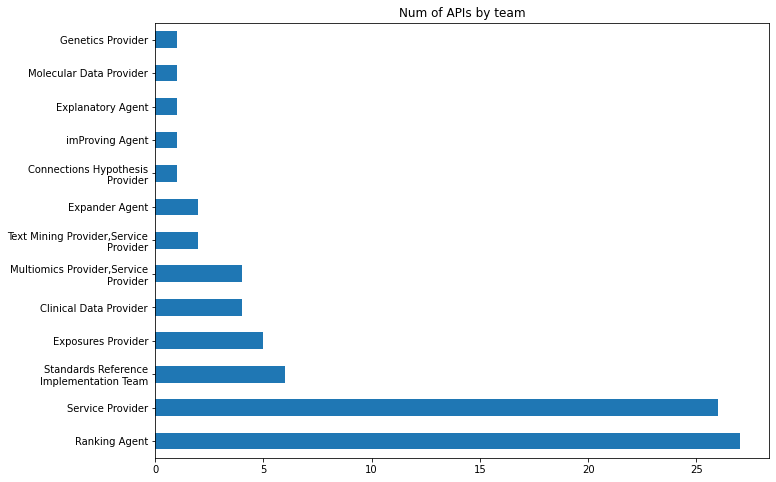

In [25]:
team_summary = translator_apis.team.value_counts().reset_index()
team_summary.columns = ['name', 'Num of APIs']
team_summary['plot_names'] = [ '\n'.join(wrap(i, 30)) for i in team_summary['name']]

team_summary.plot.barh(x='plot_names', y='Num of APIs', fontsize = 10, figsize=(11,8), rot=0, 
                       legend=False, title = "Num of APIs by team", xlabel="")
## table view
team_summary[['name', 'Num of APIs']]

#### APIs by component

,index,component
0,KP,68
1,ARA,8
2,Utility,5


<AxesSubplot:title={'center':'Num of APIs by team'}>

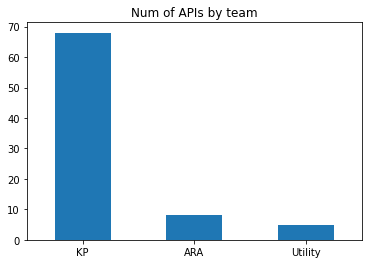

In [26]:
component_summary = translator_apis.component.value_counts().reset_index()
component_summary
component_summary.plot.bar(x='index', y='component', rot=0,
                       legend=False, title = "Num of APIs by team", xlabel="")

#### APIs by uptime status

,index,uptimeStatus
0,good,67
1,unknown,22


<AxesSubplot:title={'center':'Num of APIs by team'}>

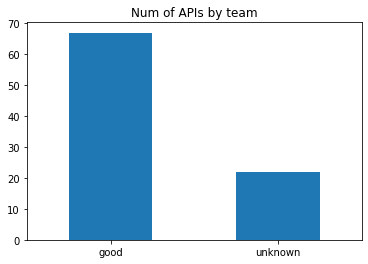

In [27]:
status_summary = translator_apis.uptimeStatus.value_counts().reset_index()
status_summary
status_summary.plot.bar(x='index', y='uptimeStatus', rot=0,
                       legend=False, title = "Num of APIs by team", xlabel="")

## using x-translator and metaKG together

The MetaKG is currently based on annotations from x-bte. The operations are all from APIs tagged translator 

### predicates by team

In [28]:
operations1 = operations_summary[['predicate', 'api_name', 'api_team']].drop_duplicates()
operations1.api_team.value_counts().reset_index(name = 'Num of unique predicates')

,index,Num of unique predicates
0,Service Provider,159
1,"Multiomics Provider,Service Provider",6
2,"Text Mining Provider,Service Provider",5
3,Standards Reference Implementation Team,3
4,Clinical Data Provider,2
